

```
# This is formatted as code
```

### Pepper Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

#### Import all the Dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import HTML 

Set all the Constants

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Pepper",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=(BATCH_SIZE)
)

Found 2475 files belonging to 2 classes.


In [7]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [8]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

Visualize some of the images from our dataset

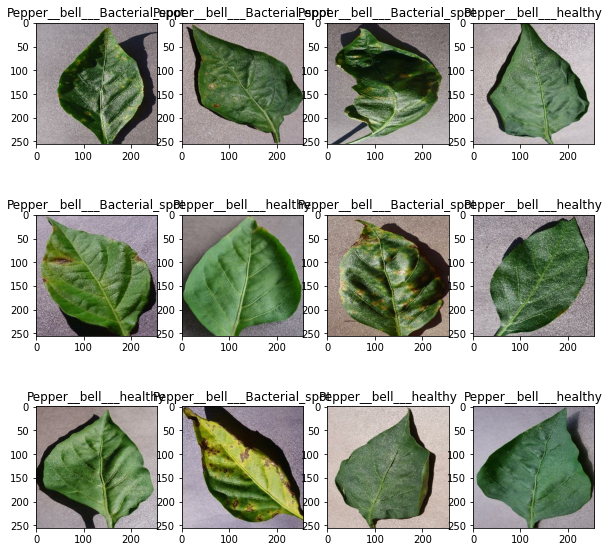

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

1..Training: Dataset to be used while training

2..Validation: Dataset to be tested against while training

3..Test: Dataset to be tested against after we trained a model

In [10]:
len(dataset)

78

In [11]:
train_size=0.8
len(dataset)*train_size

62.400000000000006

In [22]:
train_ds=dataset.take(62)
len(train_ds)

62

In [23]:
test_ds=dataset.skip(62)
len(test_ds)

16

In [24]:
val_size=0.1
len(dataset)*val_size

7.800000000000001

In [25]:
val_ds=test_ds.take(7)
len(val_ds)

7

In [26]:
test_ds=test_ds.skip(7)
len(test_ds)

9

The below function does the same above thing like splitting dataset but here we just used function

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
len(train_ds)

62

In [30]:
len(test_ds)

9

In [31]:
len(val_ds)

7

Cache, Shuffle, and Prefetch the Dataset

In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [34]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])


Applying Data Augmentation to Train Dataset

In [35]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks**

In [36]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [38]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

NOTE: Here while training the model it really takes more time based on your system specs, if your using Google colab GPU still it will take around 5 to 10 minutes to start and to complete it will take more time please be patient. 

And here below i used 50 epochs for better result You can use less epochs, have a small visualize in below visualization plot you will understand..

In [39]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=50,
)

Epoch 1/50
62/62 [==============================] - 235s 362ms/step - loss: 0.5935 - accuracy: 0.6826 - val_loss: 0.5264 - val_accuracy: 0.8393
Epoch 2/50
62/62 [==============================] - 18s 290ms/step - loss: 0.2826 - accuracy: 0.9144 - val_loss: 0.5008 - val_accuracy: 0.8661
Epoch 3/50
62/62 [==============================] - 18s 290ms/step - loss: 0.2581 - accuracy: 0.9256 - val_loss: 0.5666 - val_accuracy: 0.9196
Epoch 4/50
62/62 [==============================] - 18s 291ms/step - loss: 0.1718 - accuracy: 0.9516 - val_loss: 0.4351 - val_accuracy: 0.8929
Epoch 5/50
62/62 [==============================] - 18s 292ms/step - loss: 0.0959 - accuracy: 0.9720 - val_loss: 0.2126 - val_accuracy: 0.9821
Epoch 6/50
62/62 [==============================] - 18s 290ms/step - loss: 0.0759 - accuracy: 0.9827 - val_loss: 0.1509 - val_accuracy: 0.9732
Epoch 7/50
62/62 [==============================] - 19s 304ms/step - loss: 0.0670 - accuracy: 0.9806 - val_loss: 0.0741 - val_accuracy: 0.995

In [41]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 0s 34ms/step - loss: 0.0299 - accuracy: 0.9896


In [42]:
scores

[0.029871953651309013, 0.9895833134651184]

Plotting the Accuracy and Loss Curves

In [43]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [44]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
type(history.history['loss'])

list

In [47]:
len(history.history['loss'])

50

In [48]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.593456506729126,
 0.28263211250305176,
 0.2581426501274109,
 0.17181970179080963,
 0.0958930253982544]

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

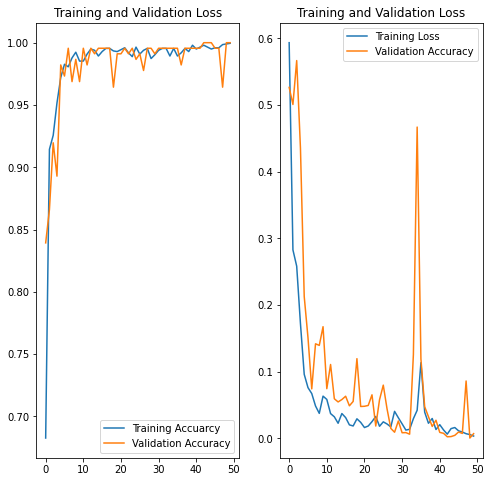

In [50]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuarcy')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label= 'Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label:  Pepper__bell___Bacterial_spot
1/1 [==============================] - 0s 43ms/step
predicted label:  Pepper__bell___Bacterial_spot


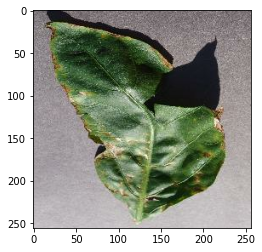

In [52]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label: ', class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print('predicted label: ', class_names[np.argmax(batch_prediction[0])])
  

Write a function for inference


In [53]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 18ms/step


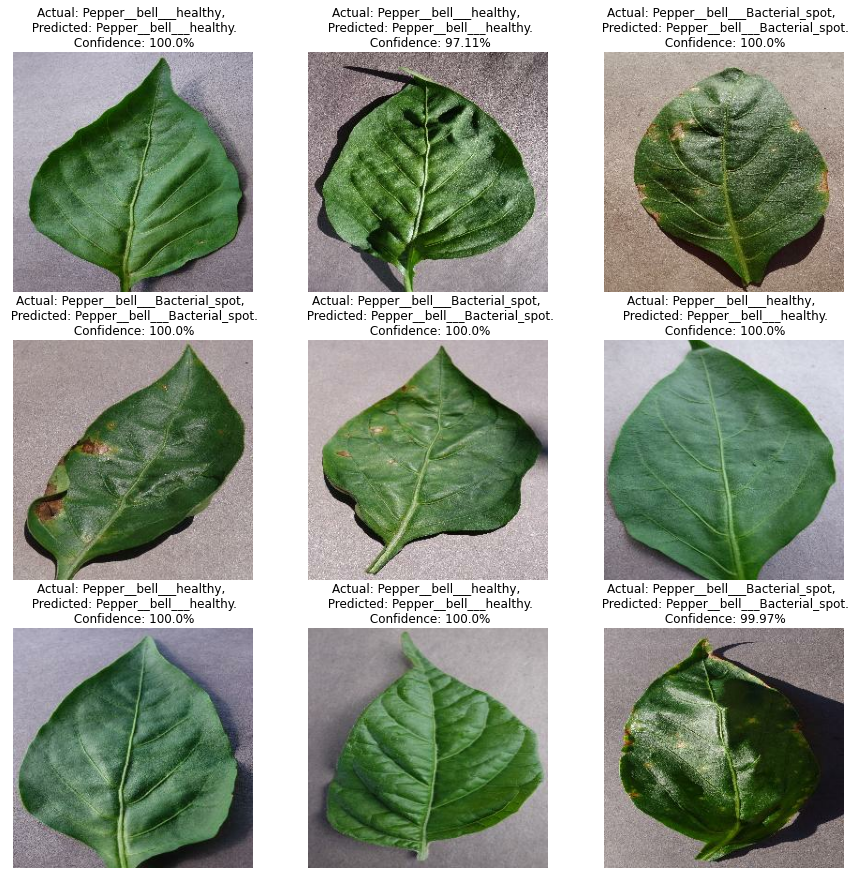

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%' )
    plt.axis('off')

If You wish to save the model, for later usage You can use the below steps...

Step 1:
Here is an example of how you can use the save_model() function to save a model:

Please make sure you have the correct path and file name when you saving model.

In [55]:
# Save the model
model.save('path/to/save/model.h5')


You can also use tf.saved_model.save() to save the model in a format that is compatible with TensorFlow serving.

In [56]:
tf.saved_model.save(model, "path/to/save/model")


### To load the saved model...

You can later load this saved model using the load_model or tf.saved_model.load() function.

Please make sure you have the correct path and file name when you loading your model.

In [58]:
loaded_model = tf.keras.models.load_model('path/to/save/model.h5')
loaded_model = tf.saved_model.load("path/to/save/model")
loaded_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f8504d33e80>

Please make sure you have the correct path and file name when you saving and loading your model.